https://hplgit.github.io/fenics-tutorial/pub/sphinx1/._ftut1005.html

In [277]:
from dolfin import *
from matplotlib import pyplot as plt

In [293]:
length, depth = 1300, 300
num_ele_along_depth = 10
ele_size = depth/num_ele_along_depth
mesh = RectangleMesh(Point(0, 0), Point(length, depth),
                     int(length/ele_size), int(depth/ele_size))

## How to assign material properties to different subdomains?


Assigning material properties to different domains is a common task in finite element simulations using FEniCS. FEniCS provides a flexible way to handle complex geometries and define material properties on different regions of the mesh. To achieve this, we can use a `MeshFunction` to label different subdomains and then use `Measures` to integrate over these labeled subdomains.


In [294]:
mat_1_sub_domain = CompiledSubDomain("x[1]<=D/2", D=depth)
mat_2_sub_domain = CompiledSubDomain("x[1]>=D/2", D=depth)

In [295]:
dim = mesh.topology().dim()
mf = MeshFunction("size_t", mesh, dim)

In [296]:
mat_1 = 1
mat_2 = 2

In [297]:
mat_1_sub_domain.mark(mf, mat_1)
mat_2_sub_domain.mark(mf, mat_2)

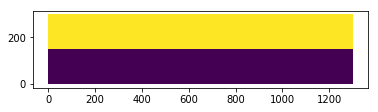

In [298]:
plot(mf)

## Define the Material Properties

Now, define the material properties for each domain. For this example, we'll consider two materials (material 1 and material 2):


In [335]:
mat_prop = {
    1: {"E": 1.0, "nu": 0.30, "rho": 5e-8},
    2: {"E": 2.0, "nu": 0.25, "rho": 10e-8}
}
g = 9.81

In [336]:
def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)


def sigma(u, mat_prop):
    E, nu = mat_prop['E'], mat_prop['nu']
    lmbda = (E * nu) / ((1 + nu) * (1 - 2 * nu))
    mu = E / (2 * (1 + nu))
    return lmbda*tr(epsilon(u))*Identity(dim) + 2*mu*epsilon(u)

In [337]:
# Define variational problem
U = VectorFunctionSpace(mesh,"CG",1)
u, v = TrialFunction(U), TestFunction(U)

In [338]:
dx = Measure("dx",subdomain_data = mf)

In [339]:
a = inner(sigma(u, mat_prop[mat_1]), epsilon(v))*dx(mat_1) + \
    inner(sigma(u, mat_prop[mat_2]), epsilon(v))*dx(mat_2)
L = dot(Constant((0, -mat_prop[mat_1]['rho']*g)), v)*dx(mat_1) + \
    dot(Constant((0, -mat_prop[mat_2]['rho']*g)), v)*dx(mat_2)

In [340]:
clamped_boundary = CompiledSubDomain("near(x[0],0)")
bc = DirichletBC(U, Constant((0,)*dim), clamped_boundary)

In [341]:
# Compute solution
u_sol = Function(U)
solve(a == L, u_sol, bc)

Calling FFC just-in-time (JIT) compiler, this may take some time.


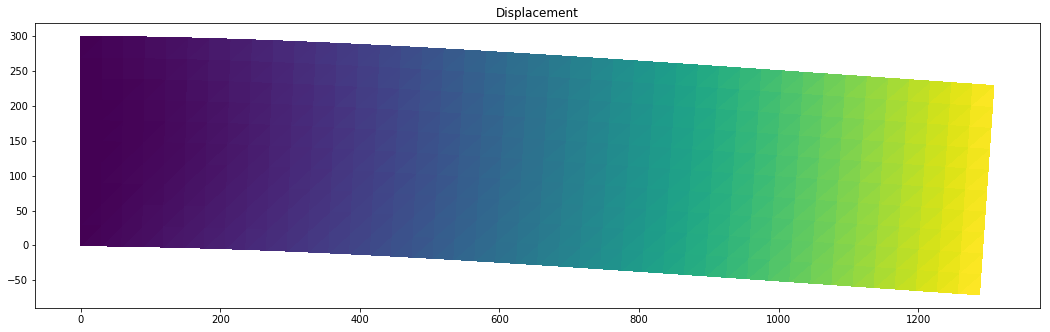

In [345]:
plt.figure(figsize=(18, 16))
# Plot solution
scale_factor = 3
plot(u_sol*scale_factor, title='Displacement', mode='displacement')